Below is code taken from the Lasagne recipes with the addition of our saliency map.

In [21]:
!wget -N https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg16.pkl

--2016-07-28 08:58:12--  https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg16.pkl
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.82.242
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.82.242|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 553459517 (528M) [binary/octet-stream]
Server file no newer than local file ‘vgg16.pkl’ -- not retrieving.



In [1]:
try:
    import cPickle as pickle
except ImportError:
    # Python 3
    import pickle
    with open('vgg16.pkl', 'rb') as f:
        model = pickle.load(f, encoding='latin-1')
else:
    # Python 2
    with open('vgg16.pkl', 'rb') as f:
        model = pickle.load(f)

weights = model['param values']  # list of network weight tensors
classes = model['synset words']  # list of class names
mean_pixel = model['mean value']  # mean pixel value (in BGR)
del model

import lasagne
from lasagne.layers import InputLayer, DenseLayer, NonlinearityLayer
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.nonlinearities import softmax

net = {}
net['input'] = InputLayer((None, 3, 224, 224))
net['conv1_1'] = ConvLayer(net['input'], 64, 3, pad=1)
net['conv1_2'] = ConvLayer(net['conv1_1'], 64, 3, pad=1)
net['pool1'] = PoolLayer(net['conv1_2'], 2)
net['conv2_1'] = ConvLayer(net['pool1'], 128, 3, pad=1)
net['conv2_2'] = ConvLayer(net['conv2_1'], 128, 3, pad=1)
net['pool2'] = PoolLayer(net['conv2_2'], 2)
net['conv3_1'] = ConvLayer(net['pool2'], 256, 3, pad=1)
net['conv3_2'] = ConvLayer(net['conv3_1'], 256, 3, pad=1)
net['conv3_3'] = ConvLayer(net['conv3_2'], 256, 3, pad=1)
net['pool3'] = PoolLayer(net['conv3_3'], 2)
net['conv4_1'] = ConvLayer(net['pool3'], 512, 3, pad=1)
net['conv4_2'] = ConvLayer(net['conv4_1'], 512, 3, pad=1)
net['conv4_3'] = ConvLayer(net['conv4_2'], 512, 3, pad=1)
net['pool4'] = PoolLayer(net['conv4_3'], 2)
net['conv5_1'] = ConvLayer(net['pool4'], 512, 3, pad=1)
net['conv5_2'] = ConvLayer(net['conv5_1'], 512, 3, pad=1)
net['conv5_3'] = ConvLayer(net['conv5_2'], 512, 3, pad=1)
net['pool5'] = PoolLayer(net['conv5_3'], 2)
net['fc6'] = DenseLayer(net['pool5'], num_units=4096)
net['fc7'] = DenseLayer(net['fc6'], num_units=4096)
net['fc8'] = DenseLayer(net['fc7'], num_units=1000, nonlinearity=None)
net['prob'] = NonlinearityLayer(net['fc8'], softmax)

lasagne.layers.set_all_param_values(net['prob'], weights)

import numpy as np
import matplotlib.pyplot as plt
# %config InlineBackend.figure_format = 'jpeg'
%matplotlib inline
import urllib.request
import io
import skimage.transform

def prepare_image(url):
    ext = url.rsplit('.', 1)[1]
    img = plt.imread(io.BytesIO(urllib.request.urlopen(url).read()), ext)
    # Resize so smallest dim = 256, preserving aspect ratio
    h, w, _ = img.shape
    if h < w:
        img = skimage.transform.resize(img, (256, w*256//h), preserve_range=True)
    else:
        img = skimage.transform.resize(img, (h*256//w, 256), preserve_range=True)
    # Central crop to 224x224
    h, w, _ = img.shape
    img = img[h//2-112:h//2+112, w//2-112:w//2+112]
    # Remember this, it's a single RGB image suitable for plt.imshow()
    img_original = img.astype('uint8')
    # Shuffle axes from 01c to c01
    img = img.transpose(2, 0, 1)
    # Convert from RGB to BGR
    img = img[::-1]
    # Subtract mean pixel value
    img = img - mean_pixel[:, np.newaxis, np.newaxis]
    # Return the original and the prepared image (as a batch of a single item)
    return img_original, lasagne.utils.floatX(img[np.newaxis])

import theano
import theano.tensor as T

def compile_saliency_function(net):
    """
    Compiles a function to compute the saliency maps and predicted classes
    for a given minibatch of input images.
    """
    inp = net['input'].input_var
    outp = lasagne.layers.get_output(net['fc8'], deterministic=True)
    max_outp = T.max(outp, axis=1)
    saliency = theano.grad(max_outp.sum(), wrt=inp)
    max_class = T.argmax(outp, axis=1)
    return theano.function([inp], [saliency, max_class])

class ModifiedBackprop(object):

    def __init__(self, nonlinearity):
        self.nonlinearity = nonlinearity
        self.ops = {}  # memoizes an OpFromGraph instance per tensor type

    def __call__(self, x):
        # OpFromGraph is oblique to Theano optimizations, so we need to move
        # things to GPU ourselves if needed.
        if theano.sandbox.cuda.cuda_enabled:
            maybe_to_gpu = theano.sandbox.cuda.as_cuda_ndarray_variable
        else:
            maybe_to_gpu = lambda x: x
        # We move the input to GPU if needed.
        x = maybe_to_gpu(x)
        # We note the tensor type of the input variable to the nonlinearity
        # (mainly dimensionality and dtype); we need to create a fitting Op.
        tensor_type = x.type
        # If we did not create a suitable Op yet, this is the time to do so.
        if tensor_type not in self.ops:
            # For the graph, we create an input variable of the correct type:
            inp = tensor_type()
            # We pass it through the nonlinearity (and move to GPU if needed).
            outp = maybe_to_gpu(self.nonlinearity(inp))
            # Then we fix the forward expression...
            op = theano.OpFromGraph([inp], [outp])
            # ...and replace the gradient with our own (defined in a subclass).
            op.grad = self.grad
            # Finally, we memoize the new Op
            self.ops[tensor_type] = op
        # And apply the memoized Op to the input we got.
        return self.ops[tensor_type](x)


class GuidedBackprop(ModifiedBackprop):
    def grad(self, inputs, out_grads):
        (inp,) = inputs
        (grd,) = out_grads
        dtype = inp.dtype
        return ((inp > 0).astype(dtype) * grd * (grd > 0).astype(dtype),)


class OurMap(ModifiedBackprop):
    def grad(self, inputs, out_grads):
        (inp,) = inputs
        (grd,) = out_grads
        dtype = inp.dtype
        return ((inp > 0).astype(dtype) * (grd > 0).astype(dtype),)
        # below is the GELU approximation derivative, indicating it's not just values features leading to interpretability
        # return (0.5 * (1 + np.tanh(inp) + inp / (np.cosh(inp)) ** 2) * 0.5 * (1 + np.tanh(grd/0.01) + grd / (np.cosh(grd/0.01)) ** 2),)

relu = lasagne.nonlinearities.rectify
relu_layers = [layer for layer in lasagne.layers.get_all_layers(net['prob'])
               if getattr(layer, 'nonlinearity', None) is relu]
modded_relu_ours = OurMap(relu)  # important: only instantiate this once!
for layer in relu_layers:
    layer.nonlinearity = modded_relu_ours
    
saliency_fn = compile_saliency_function(net)

modded_relu_guided = GuidedBackprop(relu)  # important: only instantiate this once!
for layer in relu_layers:
    layer.nonlinearity = modded_relu_guided
    
saliency_fn_guided = compile_saliency_function(net)

ERROR (theano.sandbox.cuda): nvcc compiler not found on $PATH. Check your nvcc installation and try again.
/scratch/Software/anaconda3/lib/python3.5/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")
/scratch/Software/anaconda3/lib/python3.5/site-packages/lasagne/layers/conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)
/scratch/Software/anaconda3/lib/python3.5/site-packages/lasagne/layers/conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)


In [2]:
def show_all_four(img_original, saliency, max_class, title):
    # get out the first map and class from the mini-batch
    saliency = saliency[0]
    max_class = max_class[0]
    # convert saliency from BGR to RGB, and from c01 to 01c
    saliency = saliency[::-1].transpose(1, 2, 0)
    # plot the original image and the three saliency map variants
    plt.figure(figsize=(10, 10), facecolor='w')
    plt.suptitle("Class: " + classes[max_class] + ". " + title)
    plt.subplot(2, 2, 1)
    plt.title('input')
    plt.imshow(img_original)
    plt.subplot(2, 2, 2)
    plt.title('abs. saliency')
    plt.imshow(np.abs(saliency).max(axis=-1), cmap='gray')
    plt.subplot(2, 2, 3)
    plt.title('pos. saliency')
    plt.imshow((np.maximum(0, saliency) / saliency.max()))
    plt.subplot(2, 2, 4)
    plt.title('neg. saliency')
    plt.imshow((np.maximum(0, -saliency) / -saliency.min()))
    plt.show()

In [3]:
urls = [
    'http://s.newsweek.com/sites/www.newsweek.com/files/2015/01/22/voldemort.jpg',
    'http://vignette4.wikia.nocookie.net/avatar/images/e/ea/Azula\'s_blue_fire_jets.png/revision/20090213114110',
    'http://farm5.static.flickr.com/4064/4334173592_145856d89b.jpg',
    'https://pbs.twimg.com/profile_images/378800000532546226/dbe5f0727b69487016ffd67a6689e75a.jpeg',
    'http://petus.imageg.net/PETNA_36/pimg/pPETNA-4032756_main_r200.jpg',
    'http://pixel.nymag.com/imgs/fashion/daily/2015/12/02/02-fish-makeup-GettyImages-72724330.w529.h352.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/6/6d/Puu_Oo_cropped.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/9/94/Desert_Electric.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/7/78/Wall_cloud_with_lightning_-_NOAA.jpg',
    'https://s-media-cache-ak0.pinimg.com/236x/a6/85/82/a6858246f0bfb09ae26d1919209b688a.jpg'
]

comments = [
    'Notice that modifying the fleshy colors would change the softmax, though it is not as significant for the hands.',
    'Azula is considered a sea slug, and the convolution transpose clearly helps us see why. It interprets her firebending as water.',
    'This is significantly clearer than guided backprop.',
    'The absolute saliency is a pretty figure in itself.',
    'The background should become blue and the fish outline is fuzzy.',
    'It make the scales more articulated and green to most change the softmax if is it to be classified as a water snake',
    'The map does a good job outlining the different components of the volcano. Notice the saliency map is painted with a particle effect.',
    'Only by the saliency map is it clear why the desert is considered a lakeshort.',
    'The geyser classification is odd except the map makes it clearer that it wants to see a geyser opening.',
    'The negative saliency tells us that we can change the lakeshore classification if we make the lakeshore bluer. Crucially notice the interesting sky texture of the saliency maps.'
]

Notice that modifying the fleshy colors would change the softmax, though it is not as significant for the hands.


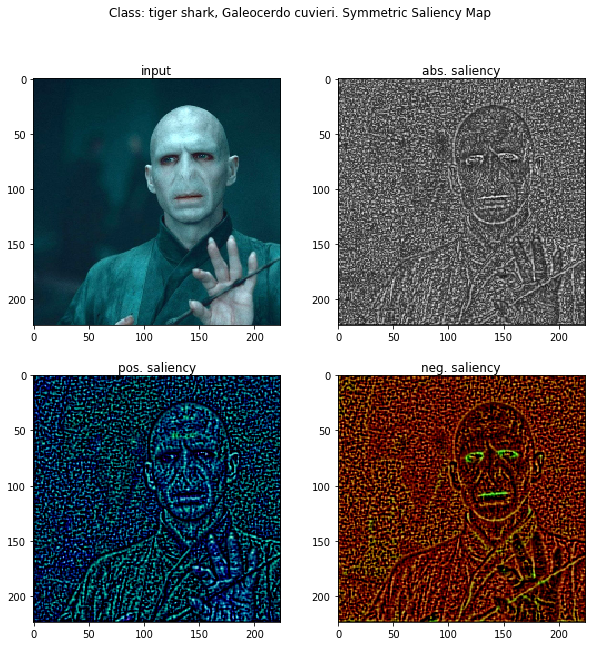

Azula is considered a sea slug, and the convolution transpose clearly helps us see why. It interprets her firebending as water.


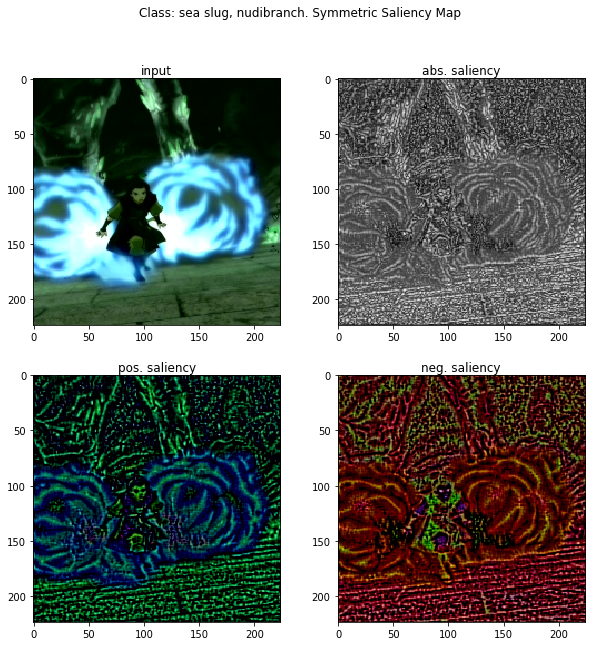

This is significantly clearer than guided backprop.


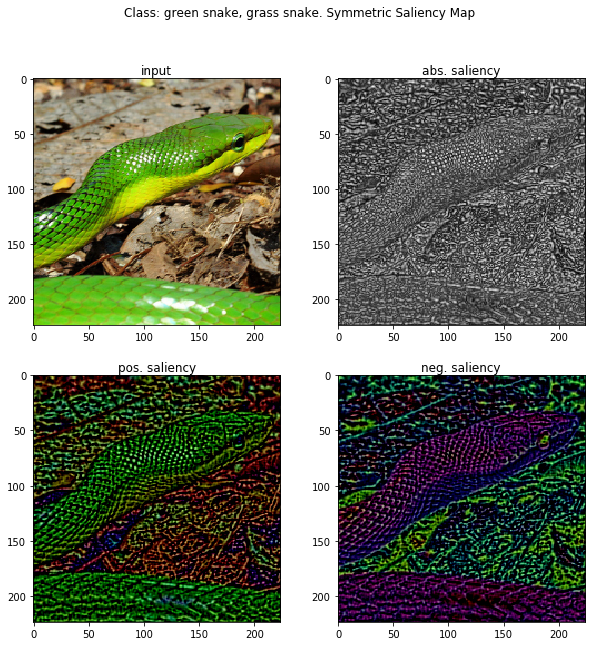

The absolute saliency is a pretty figure in itself.


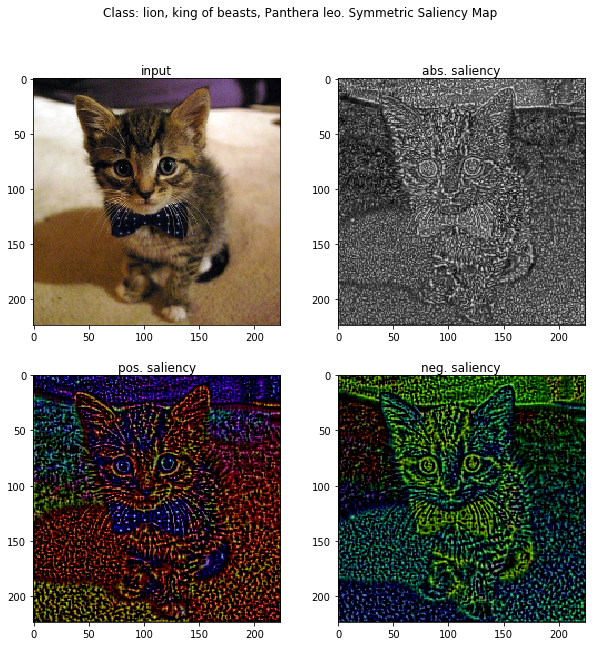

The background should become blue and the fish outline is fuzzy.


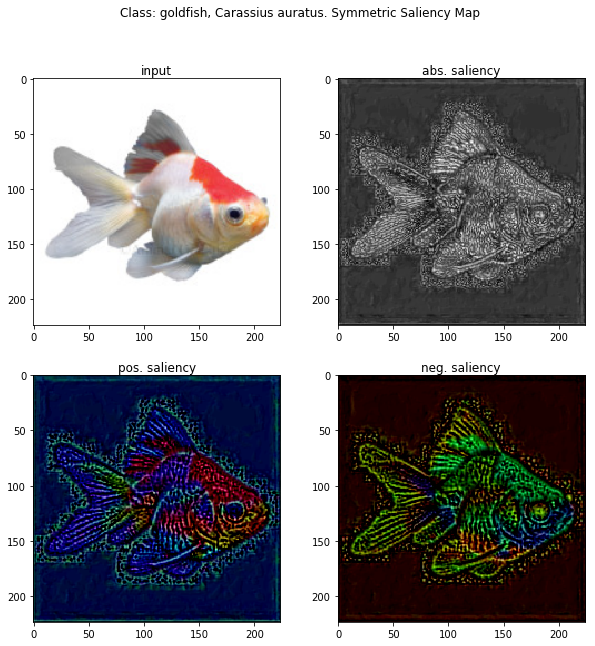

It make the scales more articulated and green to most change the softmax if is it to be classified as a water snake


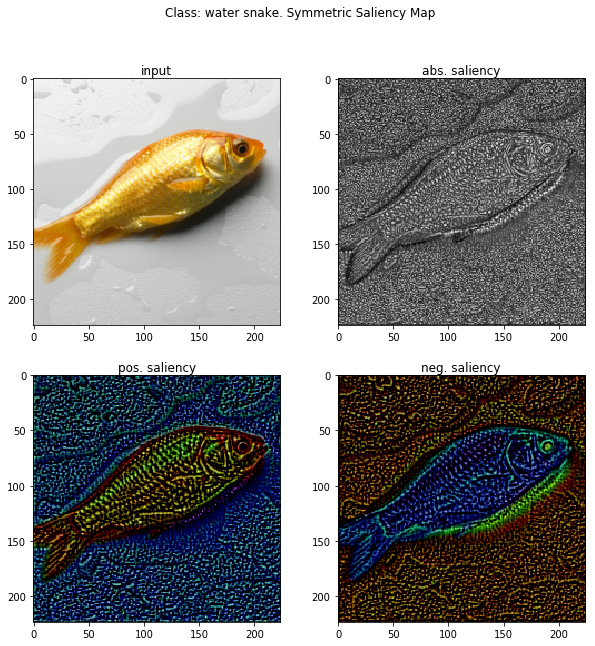

The map does a good job outlining the different components of the volcano. Notice the saliency map is painted with a particle effect.


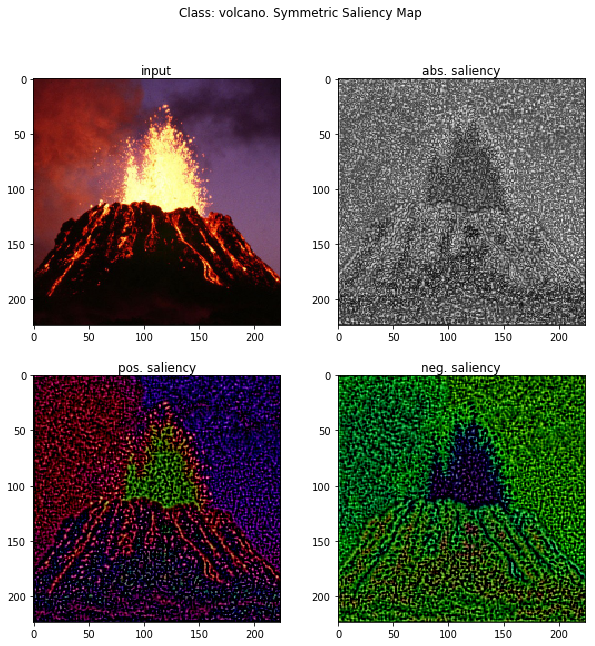

Only by the saliency map is it clear why the desert is considered a lakeshort.


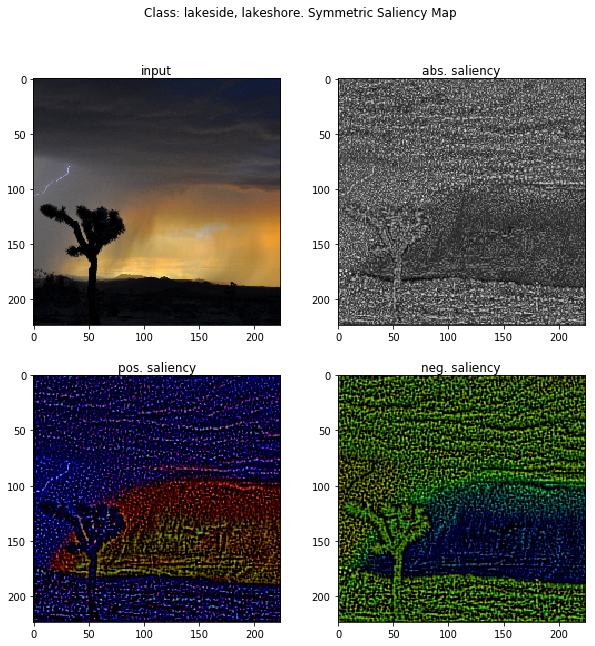

The geyser classification is odd except the map makes it clearer that it wants to see a geyser opening.


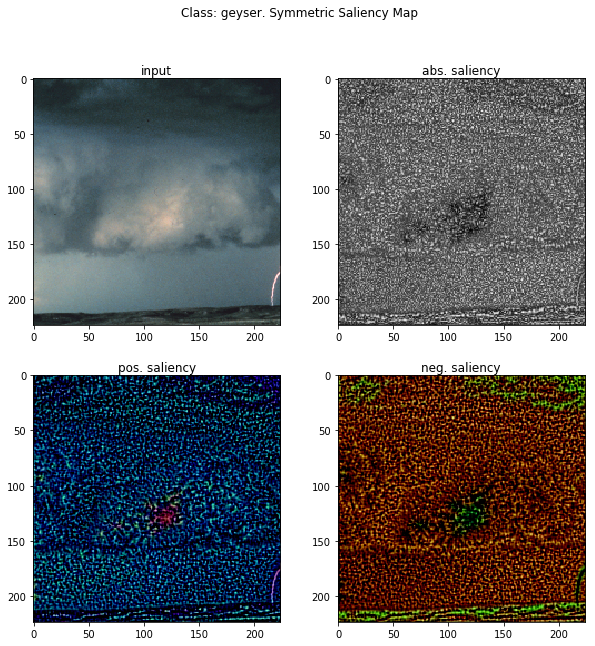

The negative saliency tells us that we can change the lakeshore classification if we make the lakeshore bluer. Crucially notice the interesting sky texture of the saliency maps.


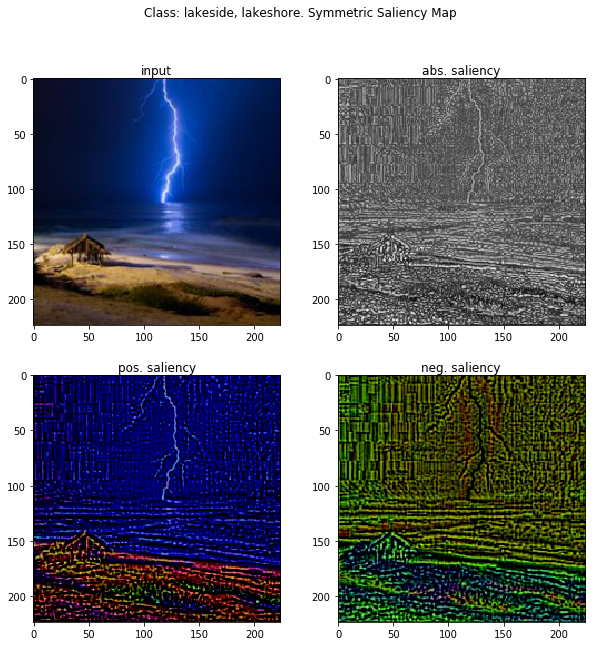

In [4]:
for i in range(len(urls)):
    print(comments[i])
    img_original, img = prepare_image(urls[i])
    saliency, max_class = saliency_fn(img)
    show_all_four(img_original, saliency, max_class, "Symmetric Saliency Map")

In [6]:
def plot_on_grid(url, col_num):
    img_original, img = prepare_image(url)
    saliency, max_class = saliency_fn(img)
    saliency = saliency[0]
    max_class = max_class[0]
    saliency = saliency[::-1].transpose(1, 2, 0)

    grid[col_num].imshow(img_original)
    grid[col_num+cols].imshow((np.maximum(0, saliency) / saliency.max()))
    
    saliency, max_class = saliency_fn_guided(img)
    saliency = saliency[0]
    max_class = max_class[0]
    saliency = saliency[::-1].transpose(1, 2, 0)
    grid[col_num+2*cols].imshow((np.maximum(0, saliency) / saliency.max()))


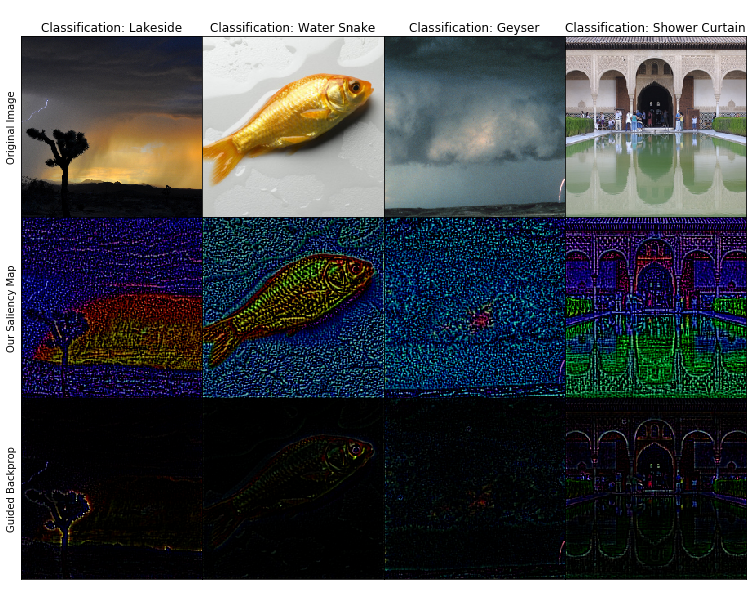

In [18]:
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('comparison.pdf') as pdf:
    fig = plt.figure(1, (20, 10))
    rows, cols = 3, 4

    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(rows, cols),
                     axes_pad=0,  # pad between axes in inch.
                     )

    # remove coordinates from showing
    for i in range(rows*cols):
        grid[i].axes.xaxis.set_ticklabels([])
        grid[i].axes.yaxis.set_ticklabels([])
        grid[i].axes.xaxis.set_ticks([])
        grid[i].axes.yaxis.set_ticks([])


    grid[0].axes.set_title('Classification: Lakeside')
    grid[0].axes.set_ylabel('Original Image')
    grid[cols].axes.set_ylabel('Our Saliency Map')
    grid[2*cols].axes.set_ylabel('Guided Backprop')
    plot_on_grid('https://upload.wikimedia.org/wikipedia/commons/9/94/Desert_Electric.jpg', 0)

    grid[1].axes.set_title('Classification: Water Snake')
    plot_on_grid('http://pixel.nymag.com/imgs/fashion/daily/2015/12/02/02-fish-makeup-GettyImages-72724330.w529.h352.jpg', 1)

    grid[2].axes.set_title('Classification: Geyser')
    plot_on_grid('https://upload.wikimedia.org/wikipedia/commons/7/78/Wall_cloud_with_lightning_-_NOAA.jpg', 2)

    grid[3].axes.set_title('\nClassification: Shower Curtain')
    plot_on_grid('http://farm4.static.flickr.com/3098/2634655735_a24b2ffca0.jpg', 3)
    
    pdf.savefig(fig, bbox_inches='tight', pad_inches=0)

In [15]:
def grid_row(url, row_num, mode='ours'):
    img_original, img = prepare_image(url)
    if mode == 'ours':
        saliency, max_class = saliency_fn(img)
    else:
        saliency, max_class = saliency_fn_guided(img)

    saliency = saliency[0]
    max_class = max_class[0]
    saliency = saliency[::-1].transpose(1, 2, 0)

    grid2[row_num].imshow(img_original)
    grid2[row_num+1].imshow((np.maximum(0, saliency) / saliency.max()))
    grid2[row_num+2].imshow((np.maximum(0, -saliency) / -saliency.min()))

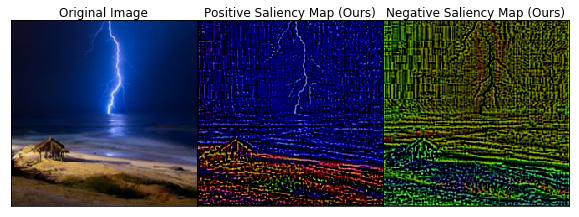

In [20]:
with PdfPages('texture.pdf') as pdf:
    fig = plt.figure(1, (10, 5))

    rows2, cols2 = 1, 3
    grid2 = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(rows2, cols2),
                     axes_pad=0,  # pad between axes in inch.
                     )


    for i in range(rows2*cols2):
        grid2[i].axes.xaxis.set_ticklabels([])
        grid2[i].axes.yaxis.set_ticklabels([])
        grid2[i].axes.xaxis.set_ticks([])
        grid2[i].axes.yaxis.set_ticks([])

    grid2[0].axes.set_title('Original Image')
    grid2[1].axes.set_title('Positive Saliency Map (Ours)')
    grid2[2].axes.set_title('Negative Saliency Map (Ours)')

    grid_row('https://s-media-cache-ak0.pinimg.com/236x/a6/85/82/a6858246f0bfb09ae26d1919209b688a.jpg', 0)

    pdf.savefig(fig, bbox_inches='tight', pad_inches=0)